In [1]:
import numpy as np

from tensorflow import keras
# Tensorflow 2.2.0 !!!!!

import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
%matplotlib inline

In [56]:
# Load mnist dataset
path = "./mnist.npz"
f = np.load(path)
x_train, y_train = f['x_train'], f['y_train']
x_test, y_test = f['x_test'], f['y_test']
f.close()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

# make the value of pixels from [0, 255] to [0, 1] for further process
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert class vectors to binary class matrics
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [3]:
# Load pretrained-model
model = keras.models.load_model("./mnist_model.h5")

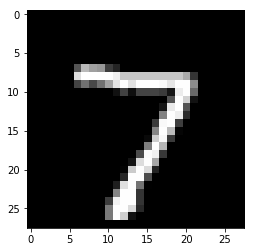

In [4]:
plt.imshow(x_test[0].reshape(28,28),cmap='gray')

In [5]:
preds = model.predict(x_test[0].reshape(1,28,28,1))
print(preds, np.max(preds))

[[1.4840211e-08 9.4211394e-10 3.5942730e-08 3.1318368e-08 1.9504790e-11
  3.3869672e-09 4.4990940e-13 9.9999928e-01 1.0695238e-09 6.8377722e-07]] 0.9999993


In [6]:
x = x_test[4].reshape(1,28,28,1)
target = y_test[4]

preds = model.predict(x)
initial_class = np.argmax(preds)

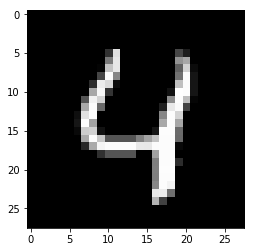

In [7]:
plt.imshow(x.reshape(28,28),cmap='gray')

In [8]:
print(target)

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [41]:
## fgsm 
fosc = []
randInitial = True

## FGSM输入参数应该是x_true 和 y_true
def fgsm(x, y):
    initial_class = np.argmax(y)
    target = tf.constant(y)
    ppreds = model(x)
    epsilon = 0.25
    
    if randInitial:
        x = x + np.random.uniform(-epsilon, epsilon, x.shape)
        x = np.clip(x, 0, 1)

    x_ = tf.Variable(x)

    # Get the loss and gradient of the loss wrt the inputs
    with tf.GradientTape() as tape:
        loss = keras.losses.categorical_crossentropy(tf.expand_dims(target,0), model(x_))
        grads = tape.gradient(loss, x_)
    # Get the sign of the gradient
    delta = tf.sign(grads)

    # Perturb the image
    x_adv = x_ + epsilon*delta
    x_adv = tf.clip_by_value(x_adv, clip_value_min=-1, clip_value_max=1)
    x_adv = tf.Variable(x_adv)

    preds = model(x_adv)
    print("target is %d" % initial_class)
    print("Preivious pred: %.5f, Attacked pred: %.5f" % (ppreds[0][initial_class].numpy(),preds[0][initial_class].numpy()))

    with tf.GradientTape() as tape2:
        loss = keras.losses.categorical_crossentropy(tf.expand_dims(target,0), model(x_adv))
        grads2 = tape2.gradient(loss, x_adv)
#             print(grads2)  # size = 1，28，28，1
#             grad_norm = tf.norm(grads2,ord=1).numpy().reshape(-1)
        grad_norm = np.linalg.norm(grads2.numpy().reshape(-1), ord=1)
        grads2_flat = grads2.numpy().reshape(-1)
        diff = x_adv.numpy().reshape(-1)- x_.numpy().reshape(-1)
        fosc_item = -np.dot(grads2_flat, diff) + epsilon * grad_norm
        print("fgsm-fsoc: %.5f\n" % fosc_item)
        fosc.append(fosc_item)
            
    return x_adv

In [42]:
for i in range(20):
    img = x_train[i].reshape(1,28,28,1)
    label = y_train[i]
    xgen = fgsm(img, label)
    # cv2.imwrite("/Users/chenjl666/DNNtesting/FGSM_jupyter_data/FGSM_%d.png" % (i+1), xgen.numpy().reshape(28,28,1)*255)

target is 5
Preivious pred: 0.99997, Attacked pred: 0.00139
fgsm-fsoc: 19.02958

target is 0
Preivious pred: 1.00000, Attacked pred: 0.13922
fgsm-fsoc: 11.92149

target is 4
Preivious pred: 0.99984, Attacked pred: 0.00820
fgsm-fsoc: 22.15564

target is 1
Preivious pred: 0.99999, Attacked pred: 0.00238
fgsm-fsoc: 14.20344

target is 9
Preivious pred: 0.99996, Attacked pred: 0.00001
fgsm-fsoc: 26.95221

target is 2
Preivious pred: 1.00000, Attacked pred: 0.01050
fgsm-fsoc: 24.45922

target is 1
Preivious pred: 1.00000, Attacked pred: 1.00000
fgsm-fsoc: 0.00000

target is 3
Preivious pred: 1.00000, Attacked pred: 0.01239
fgsm-fsoc: 27.26135

target is 1
Preivious pred: 1.00000, Attacked pred: 0.33794
fgsm-fsoc: 10.77309

target is 4
Preivious pred: 1.00000, Attacked pred: 0.00072
fgsm-fsoc: 30.88273

target is 3
Preivious pred: 0.99998, Attacked pred: 0.00298
fgsm-fsoc: 22.64727

target is 5
Preivious pred: 1.00000, Attacked pred: 0.00095
fgsm-fsoc: 18.99954

target is 3
Preivious pred: 1

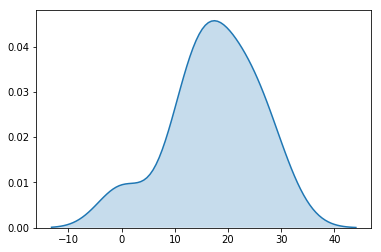

In [43]:
import seaborn as sns

fig,ax=plt.subplots()
sns.kdeplot(fosc,shade=True)
plt.show()

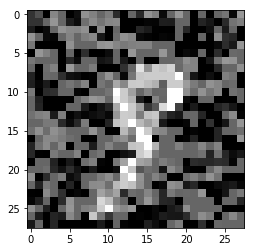

In [44]:
plt.imshow(xgen.numpy().reshape(28,28),cmap='gray')

In [52]:
pgd_fosc = []

def pgd(x, y):
#     x = x_test[1].reshape(1,28,28,1)
    # target = y_test[1]
    ppreds = model(x)
    initial_class = np.argmax(y)
    target = tf.constant(y)
    epsilon = 0.03
    bound = 0.15
    epoch = 20

    if randInitial:
        x = x + np.random.uniform(-epsilon, epsilon, x.shape)
        x = np.clip(x, 0, 1)
    
    x_ = tf.Variable(x)
    x_adv = tf.Variable(x)

    for i in range(epoch): 
        # Get the loss and gradient of the loss wrt the inputs
        with tf.GradientTape() as tape:
            loss = keras.losses.categorical_crossentropy(tf.expand_dims(target,0), model(x_adv))
            grads = tape.gradient(loss, x_adv)
        # Get the sign of the gradient
        delta = tf.sign(grads)

        # Perturb the image
        x_adv.assign_add(epsilon*delta)
        x_adv = tf.clip_by_value(x_adv, clip_value_min=x_-bound, clip_value_max=x_+bound)
        x_adv = tf.clip_by_value(x_adv, clip_value_min=-1, clip_value_max=1)
        x_adv = tf.Variable(x_adv)
        
    preds = model(x_adv)
    print("target is %d" % initial_class)
    print("Preivious pred: %.5f, Attacked pred: %.5f" % (ppreds[0][initial_class].numpy(),preds[0][initial_class].numpy()))

    
    with tf.GradientTape() as tape2:
        loss = keras.losses.categorical_crossentropy(tf.expand_dims(target,0), model(x_adv))
        grads2 = tape2.gradient(loss, x_adv)
        grad_norm = np.linalg.norm(grads2.numpy().reshape(-1), ord=1)
        grads2_flat = grads2.numpy().reshape(-1)
        diff = x_adv.numpy().reshape(-1)- x_.numpy().reshape(-1)
        fosc_item = -np.dot(grads2_flat, diff) + bound * grad_norm
        print("pgd-fsoc: %.5f\n" % fosc_item)
        pgd_fosc.append(fosc_item)
        
    return x_adv

In [53]:
for i in range(10):
    img = x_train[i].reshape(1,28,28,1)
    label = y_train[i]
    xgen = pgd(img, label)
    # cv2.imwrite("/Users/chenjl666/DNNtesting/FGSM_jupyter_data/PGD_%d.png" % (i+1), xgen.numpy().reshape(28,28,1)*255)

target is 5
Preivious pred: 0.99997, Attacked pred: 0.00035
pgd-fsoc: 3.01292

target is 0
Preivious pred: 1.00000, Attacked pred: 0.18823
pgd-fsoc: 1.57099

target is 4
Preivious pred: 0.99984, Attacked pred: 0.00037
pgd-fsoc: 3.29669

target is 1
Preivious pred: 0.99999, Attacked pred: 0.00402
pgd-fsoc: 3.01649

target is 9
Preivious pred: 0.99996, Attacked pred: 0.00000
pgd-fsoc: 4.65290

target is 2
Preivious pred: 1.00000, Attacked pred: 0.00471
pgd-fsoc: 3.79916

target is 1
Preivious pred: 1.00000, Attacked pred: 1.00000
pgd-fsoc: 0.00000

target is 3
Preivious pred: 1.00000, Attacked pred: 0.02402
pgd-fsoc: 3.19117

target is 1
Preivious pred: 1.00000, Attacked pred: 0.10317
pgd-fsoc: 2.13952

target is 4
Preivious pred: 1.00000, Attacked pred: 0.00001
pgd-fsoc: 2.54056



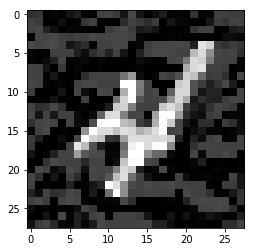

In [54]:
plt.imshow(xgen.numpy().reshape(28,28),cmap='gray')

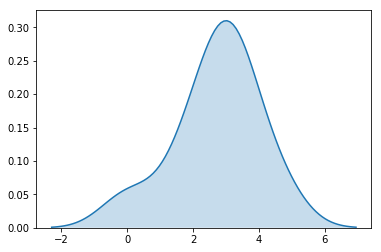

In [55]:
fig,ax=plt.subplots()
sns.kdeplot(pgd_fosc,shade=True)
plt.show()

In [83]:
imgx = cv2.imread("/Users/chenjl666/DNNtesting/FGSM_jupyter_data/FGSM_1.png")

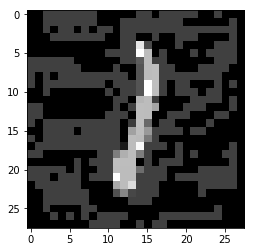

In [86]:
plt.imshow(imgx, cmap='gray')

AttributeError: module 'tensorflow.keras' has no attribute 'Conv2D'